Importing all the necessary modules

In [1]:
import os
import cv2
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter
import time
import matplotlib.pyplot as plt
import math
import datetime
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, UpSampling2D, BatchNormalization
from tensorflow.keras.models import Model
from google.colab.patches import cv2_imshow
# from guidedfilter import guided_filter
# import BM3D

Paths to various folders and files

In [2]:
path = '/Users/rohitramesh4547gmail.com/Desktop/IITG/Semester-7/BTP/Good_Illumination_Images'
store_path = '/Users/rohitramesh4547gmail.com/Desktop/IITG/Semester-7/BTP/Darkened_Images_0.2'
fold_path = '/Users/rohitramesh4547gmail.com/Desktop/IITG/Semester-7/BTP'
enhanced_path = '/Users/rohitramesh4547gmail.com/Desktop/IITG/Semester-7/BTP/Enhanced_Images_Histogram_Equalization'
test_path = fold_path + '/test_dark.jpeg'
path = '/content/drive/MyDrive/Illumination_Enhancement_BTP/Good_Illumination_Images'
store_path_1 = '/content/drive/MyDrive/Illumination_Enhancement_BTP/Darkened_Images_0.1'
store_path_2 = '/content/drive/MyDrive/Illumination_Enhancement_BTP/Darkened_Images_0.2'
store_path_3 = '/content/drive/MyDrive/Illumination_Enhancement_BTP/Darkened_Images_0.3'
rain_path = '/content/drive/MyDrive/Illumination_Enhancement_BTP/Rain_Images'
snow_path = '/content/drive/MyDrive/Illumination_Enhancement_BTP/Snow_Images'
ltsitd_long_path = '/content/drive/MyDrive/Illumination_Enhancement_BTP/LTSITD/long_jpeg'
ltsitd_short_path = '/content/drive/MyDrive/Illumination_Enhancement_BTP/LTSITD/short_jpeg'
all_im_path = '../input/btp-dataset'

For Google Colab Only!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Saving images in Darkened_Images_0.2

In [ ]:
for file_name in os.listdir(path):
    try:
        img = Image.open(path + '/' + file_name)
        enhancer = ImageEnhance.Brightness(img)
        factor = 0.2
        im_output = enhancer.enhance(factor)
        im_output.save(store_path_2 + '/darkened_' + file_name)
    except Exception as e:
        print(e)

Using Bright/Dark Channel Prior Method

In [ ]:
def get_illumination_channel(I, w):
    M, N, _ = I.shape
    padded = np.pad(I, ((int(w/2), int(w/2)),
                        (int(w/2), int(w/2)), (0, 0)), 'edge')
    darkch = np.zeros((M, N))
    brightch = np.zeros((M, N))
    for i, j in np.ndindex(darkch.shape):
        # dark channel
        darkch[i, j] = np.min(padded[i:i + w, j:j + w, :])
        # bright channel
        brightch[i, j] = np.max(padded[i:i + w, j:j + w, :]) 
    return darkch, brightch

In [ ]:
darkch, brightch = get_illumination_channel(test_image_1, 5)
cv2.imwrite('darkch.jpeg', darkch)
cv2.imwrite('brightch.jpeg', brightch)

In [ ]:
def get_atmosphere(I, brightch, p=0.1):
    M, N = brightch.shape
    flatI = I.reshape(M*N, 3) # reshaping image array
    flatbright = brightch.ravel() #flattening image array
    # sorting and slicing
    searchidx = (-flatbright).argsort()[:int(M*N*p)] 
    A = np.mean(flatI.take(searchidx, axis=0),
                dtype=np.float64, axis=0)
    return A

In [ ]:
A = get_atmosphere(test_image_1, brightch)

In [ ]:
def get_initial_transmission(A, brightch):
    A_c = np.max(A) / 255
    # finding initial transmission map
    init_t = (brightch - A_c) / (1. - A_c) 
    return init_t

In [ ]:
init_map = get_initial_transmission(A, brightch)
cv2.imwrite('init_map.jpeg', init_map)

In [ ]:
def get_corrected_transmission(I, A, darkch, brightch,
                               init_t, alpha, omega, w):
    im = np.empty(I.shape, I.dtype);
    for ind in range(0, 3):
        #divide pixel values by atmospheric light
        im[:, :, ind] = I[:, :, ind] / A[ind]
    # dark channel transmission map
    dark_c, _ = get_illumination_channel(im, w)
    # corrected dark transmission map
    dark_t = 1 - omega * dark_c 
    # initializing corrected transmission map
    # with initial transmission map
    corrected_t = init_t
    # difference between transmission maps
    diffch = brightch - darkch 
    for i in range(diffch.shape[0]):
        for j in range(diffch.shape[1]):
            if(diffch[i, j] < alpha):
                corrected_t[i, j] = dark_t[i, j] * init_t[i, j]
    return np.abs(corrected_t)

In [ ]:
corrected_map = get_corrected_transmission(test_image_1, A,
                                           darkch, brightch,
                                           init_map, 0.4, 0.75, 5)
cv2.imwrite('corrected_map.jpeg', corrected_map)

In [ ]:
def get_final_image(I, A, refined_t, tmin):
    # duplicating the channel of 2D refined map to 3 channels
    refined_t_broadcasted = np.broadcast_to(refined_t[:, :, None],
                                            (refined_t.shape[0],
                                             refined_t.shape[1], 3)) 
    J = ((I - A) / (np.where(refined_t_broadcasted < tmin,
                             tmin, refined_t_broadcasted))) 

    # normalized image
    return (J - np.min(J))/(np.max(J) - np.min(J)) 

In [ ]:
final = get_final_image(test_image_1, A, corrected_map, 0.1)
final = (final * 255).astype(np.uint8)
cv2.imwrite('final.jpeg', final)

In [ ]:
def reduce_init_t(init_t):
    init_t = (init_t*255).astype(np.uint8) 
    xp = [0, 32, 255]
    fp = [0, 32, 48]
    x = np.arange(256) # creating array [0,...,255]
    # interpreting fp according to xp in range of x
    table = np.interp(x, xp, fp).astype('uint8') 
    init_t = cv2.LUT(init_t, table) # lookup table
    # normalizing the transmission map
    init_t = init_t.astype(np.float64)/255 
    return init_t

In [ ]:
def dehaze(im, tmin=0.1, w=5, alpha=0.4, omega=0.75,
           p=0.1, eps=1e-3, reduce=False):
    # Convert the input to a float array.
    I = np.asarray(im, dtype=np.float64) 
    I = I[:, :, :3] / 255
    m, n, _ = I.shape
    Idark, Ibright = get_illumination_channel(I, w)
    A = get_atmosphere(I, Ibright, p)
    # print("Obtained atmosphere lighting")
    init_t = get_initial_transmission(A, Ibright) 
    # print("Obtained initial transmission map")
    if reduce:
        init_t = reduce_init_t(init_t)
        # print("Obtained reduced transmission map")
    corrected_t = get_corrected_transmission(I, A,
                                             Idark, Ibright,
                                             init_t, alpha, omega, w)
    # print("Obtained corrected transmission map")
    normI = (I - I.min()) / (I.max() - I.min())
    # applying guided filter
    refined_t = guided_filter(normI, corrected_t, w, eps) 
    # print("Obtained image after applying guided filter")
    
    J_refined = get_final_image(I, A, refined_t, tmin)
    # print("Obtained final image before enhancement")
    
    enhanced = (J_refined * 255).astype(np.uint8)
    f_enhanced = cv2.detailEnhance(enhanced, sigma_s=10,
                                   sigma_r=0.15)
    f_enhanced = cv2.edgePreservingFilter(f_enhanced,
                                          flags=1, sigma_s=64,
                                          sigma_r=0.2)
    return f_enhanced

In [ ]:
f_enhanced = dehaze(test_image_1, tmin=0.1, w=5,
                    alpha=0.4, omega=0.75, p=0.1, eps=1e-3,
                    reduce=False)
cv2.imwrite('enhanced_1.jpeg', f_enhanced)

True

Pixel Enhancement Method (Increasing value in HSV image)

In [ ]:
def increase_brightness(img, value):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv[:, :, 2] += value
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return img

In [ ]:
pixel_enhanced = increase_brightness(test_image_1, 50)
cv2.imwrite('/content/pixel_enhanced.jpeg', pixel_enhanced)

True

Gamma Correction Method

In [ ]:
def increase_contrast_brightness(img, alpha, beta, gamma):
    new_image = np.zeros(img.shape, img.dtype)
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            for c in range(img.shape[2]):
                new_image[y, x, c] = np.clip(alpha * img[y, x, c] + beta,
                                             0, 255)
    lookUpTable = np.empty((1, 256), np.uint8)
    for i in range(256):
        lookUpTable[0, i] = np.clip(pow(i / 255.0, gamma) * 255.0,
                                    0, 255)
    res = cv2.LUT(new_image, lookUpTable)
    return new_image, res

In [ ]:
image_linear_transform, gamma_corrected = increase_contrast_brightness(
    test_image_1, 2.2, 50, 0.4)
cv2.imwrite('/content/gamma_corrected.jpeg', gamma_corrected)

True

Histogram Equalization Method and CLAHE Method

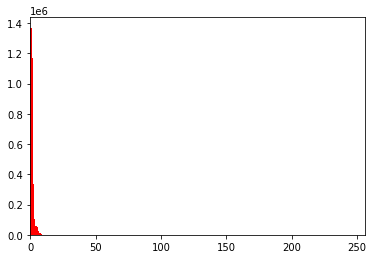

In [ ]:
hist, bins = np.histogram(test_image_1.flatten(), 256, [0, 256])
plt.hist(test_image_1.flatten(), 256, [0, 256], color='r')
plt.xlim([0, 256])
plt.show()

In [ ]:
def histogram_equalization_and_CLAHE(img_in):
    b,g,r = cv2.split(img_in) 
    equ_b = cv2.equalizeHist(b)
    equ_g = cv2.equalizeHist(g)
    equ_r = cv2.equalizeHist(r)
    he_final = cv2.merge((equ_b, equ_g, equ_r))
    
    clahe = cv2.createCLAHE(clipLimit=40)
    clahe_b = clahe.apply(equ_b)
    clahe_g = clahe.apply(equ_g)
    clahe_r = clahe.apply(equ_r)
    clahe_final = cv2.merge((clahe_b, clahe_g, clahe_r))
    
    cv2.imwrite('histogram_equalization.jpeg', he_final)
    cv2.imwrite('clahe.jpeg', clahe_final)
    return he_final, clahe_final

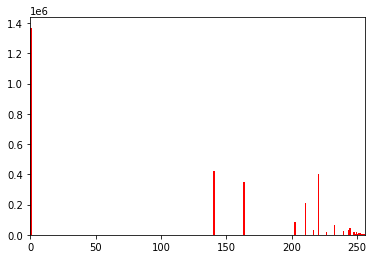

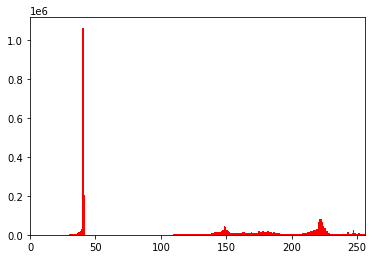

In [ ]:
he_final, clahe_final = histogram_equalization_and_CLAHE(test_image_1)
hist, bins = np.histogram(he_final.flatten(), 256, [0, 256])
plt.hist(he_final.flatten(), 256, [0, 256], color='r')
plt.xlim([0, 256])
plt.show()
hist, bins = np.histogram(clahe_final.flatten(), 256, [0, 256])
plt.hist(clahe_final.flatten(), 256, [0, 256], color='r')
plt.xlim([0, 256])
plt.show()

In [ ]:
gray_img = cv2.cvtColor(test_image_1, cv2.COLOR_BGR2GRAY)
hist = cv2.calcHist(gray_img, [0], None, [256], [0, 256])
plt.subplot(121)
plt.title("Image1")
plt.xlabel('bins')
plt.ylabel("No of pixels")
plt.plot(hist)
plt.show()
gray_img_eqhist = cv2.equalizeHist(gray_img)
hist = cv2.calcHist(gray_img_eqhist, [0], None, [256], [0, 256])
plt.subplot(121)
plt.title("Image2")
plt.xlabel('bins')
plt.ylabel("No of pixels")
plt.plot(hist)
plt.show()
gray_img_eqhist = cv2.cvtColor(gray_img_eqhist, cv2.COLOR_GRAY2BGR)
cv2.imwrite('/content/gray_img_eqhist.jpeg', gray_img_eqhist)

Using CLAHE (Contrast Limited Adaptive Histogram Equalization)

In [ ]:
gray_img_eqhist = cv2.equalizeHist(gray_img)
clahe = cv2.createCLAHE(clipLimit=40)
gray_img_clahe = clahe.apply(gray_img_eqhist)
gray_img_clahe = cv2.cvtColor(gray_img_clahe, cv2.COLOR_GRAY2BGR)
cv2.imwrite('/content/gray_img_clahe.jpeg', gray_img_clahe)

OTSU Binarization 

In [ ]:
ret, thresh = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# thresh = Image.fromarray(thresh)
# thresh.show()

Adaptive Thresholding

In [ ]:
thresh1 = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 31, 3)
thresh2 = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 13, 5)
final = np.concatenate((thresh1, thresh2), axis = 1)
# final = Image.fromarray(final)
# final.show()

Test-Image

In [ ]:
original_image = np.asarray(original_image, dtype=np.float64)
print(original_image.shape)

Simple Pixel Enhancement

In [ ]:
print(stack_bright.shape)
stack_bright = np.asarray(stack_bright, dtype=np.float64)
print("Simple Pixel Enhancement MSE = ", mse(stack_bright, original_image))

Linear Pixel Transformation Method

In [ ]:
print(image_linear_transform.shape)
image_linear_transform = np.asarray(image_linear_transform, dtype=np.float64)
print("Linear Pixel Transformation Method MSE = ", mse(image_linear_transform, original_image))

Linear Pixel Transformation Method with Gamma Correction

In [ ]:
print(gamma_corrected.shape)
gamma_corrected = np.asarray(gamma_corrected, dtype=np.float64)
print("Linear Pixel Transformation Method with Gamma Correction MSE = ", mse(gamma_corrected, original_image))

Histogram Equalization Method

In [ ]:
gray_img_eqhist = cv2.cvtColor(gray_img_eqhist, cv2.COLOR_GRAY2BGR)
print(gray_img_eqhist.shape)
gray_img_eqhist = np.asarray(gray_img_eqhist, dtype=np.float64)
print("Histogram Equalization Method = ", mse(gray_img_eqhist, original_image))

CLAHE Method

In [ ]:
gray_img_clahe = cv2.cvtColor(gray_img_clahe, cv2.COLOR_GRAY2BGR)
print(gray_img_clahe.shape)
gray_img_clahe = np.asarray(gray_img_clahe, dtype=np.float64)
print("CLAHE Method MSE = ", mse(gray_img_clahe, original_image))

Adaptive Thresholding Method - MEAN

In [ ]:
thresh1 = cv2.cvtColor(thresh1, cv2.COLOR_GRAY2BGR)
print(thresh1.shape)
thresh1 = np.asarray(thresh1, dtype=np.float64)
print("Adaptive Thresholding Method - MEAN MSE = ", mse(thresh1, original_image))

Adaptive Thresholding Method - GAUSSIAN

In [ ]:
thresh2 = cv2.cvtColor(thresh2, cv2.COLOR_GRAY2BGR)
print(thresh2.shape)
thresh2 = np.asarray(thresh2, dtype=np.float64)
print("Adaptive Thresholding Method - GAUSSIAN MSE = ", mse(thresh2, original_image))

OTSU Binarization Method 

In [ ]:
thresh = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
print(thresh.shape)
thresh = np.asarray(thresh, dtype=np.float64)
print("OTSU Binarization Method  MSE = ", mse(thresh, original_image))

Using Histogram Equalization on Several Images for Testing

In [ ]:
count = 0
total_mse = 0
for file_name in os.listdir(store_path):
    try:
        im_to_enhance = cv2.imread(store_path + '/' + file_name)
        im_original = Image.open(path + '/' + file_name[9:])
        original = np.asarray(im_original, dtype=np.float64)
        gray_img = cv2.cvtColor(im_to_enhance, cv2.COLOR_BGR2GRAY)
        start_time = time.time()
        result = cv2.equalizeHist(gray_img)
        end_time = time.time()
        print(end_time - start_time)
        result = cv2.cvtColor(result, cv2.COLOR_GRAY2BGR)
        result = np.asarray(result, dtype=np.float64)
        print(result.shape)
        print(original.shape)
        current_mse = mse(result, original)
        count += 1
        print(f"image - {count} is enhanced and the mse for the image was {current_mse}")
        total_mse += current_mse
        result = np.asarray(result, dtype=np.uint8)
        im_output = Image.fromarray(result)
        im_output.save(enhanced_path + '/enhanced_eq_hist' + file_name[9:])
    except Exception as e:
        print(e)
    if count >= 10:
        break
print("Mean MSE = ", total_mse / 10)

Default parameters for Tan-Triggs

In [ ]:
rows = gray_img.shape[0]
cols = gray_img.shape[1]

Gamma Correction 

In [ ]:
gamma = 0.2

Difference of Gaussian (DoG) Filterings

In [ ]:
sigma_0 = 1
sigma_1 = 2

Contrast Equalization

In [ ]:
alpha = 0.1
tao = 10

Tan - Triggs Method

In [ ]:
gamma_corrected = gray_img ** gamma
kernel_0 = ImageFilter.GaussianBlur(radius=sigma_0)
kernel_1 = ImageFilter.GaussianBlur(radius=sigma_1)
# kernel_0 = np.ones((3 * sigma_0, 3 * sigma_0))
# kernel_1 = np.ones((3 * sigma_1 + 1, 3 * sigma_1 + 1))

In [ ]:
image_0 = Image.fromarray(gamma_corrected).convert('L').filter(kernel_0)
image_1 = Image.fromarray(gamma_corrected).convert('L').filter(kernel_1)

In [ ]:
image_0 = np.array(image_0)
image_1 = np.array(image_1)

In [ ]:
image = image_0 - image_1

In [ ]:
image = image / ((np.mean((abs(image.flatten())) ** alpha)) ** (1 / alpha))
image = image / (np.mean([np.min(tao * np.ones((1, rows * cols))) ** alpha, np.min(abs(gray_img.flatten().reshape((1, rows * cols)))) ** alpha]) ** (1 / alpha))
image = tao * np.tanh(image / tao)

In [ ]:
max_image = np.max(np.max(image))
min_image = np.min(np.min(image))

In [ ]:
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        image[i][j] = math.ceil(((image[i][j] - min_image) / (max_image - min_image)) * 255)
image = np.asarray(image, dtype=np.uint8)
image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
display_image = Image.fromarray(image).convert('RGB')
display_image.save('/content/tan_triggs_IMG_2838.jpeg')

BM3D De-Noising Technique

In [ ]:
! pip install bm3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! python BM3D.py

Image Read
The PSNR of basic image is 29.912951045496143 dB.

Basic estimate has been saved successfully.

The running time of basic estimate is 392.58781695365906 seconds.

The PSNR of final image is 29.150656957072517 dB.

Final estimate has been saved successfully.

The running time of final estimate is 477.4651083946228 seconds.



In [ ]:
import bm3d
from bm3d import bm3d_rgb, BM3DProfile

In [ ]:
image_noisy = cv2.imread('/content/denoised.jpeg') / 255
# y = np.array(Image.open('/content/denoised.jpeg')) / 255
# denoised_image = bm3d.bm3d(image_noisy, sigma_psd=30/255, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
y_est = bm3d_rgb(image_noisy, sigma_psd=30/255)
y_est = y_est * 255
cv2.imwrite('denoised_new.jpeg', y_est)

Initializing image size for the Model and<br>
data arrays for storing the images

In [ ]:
im_size = 512
images_darkened = []
images_normal = []

Obtaining the entire dataset for training and testing purposes

In [ ]:
for file in os.listdir(path):
  if file.endswith('jpeg') and 'darkened' not in file:
    img_light = cv2.imread(os.path.join(path, file))
    img_light = cv2.cvtColor(img_light, cv2.COLOR_BGR2HSV)
    img_light = img_light[:, :, 2]
    img_light = cv2.resize(img_light, (im_size, im_size))
    img_light = img_light / 255
    images_normal.append(img_light)
    img_dark_2 = cv2.imread(os.path.join(store_path_2,
                                         'darkened_' + file))
    img_dark_2 = cv2.rotate(img_dark_2,
                            rotateCode=cv2.ROTATE_90_CLOCKWISE)
    img_dark_2 = cv2.cvtColor(img_dark_2, cv2.COLOR_BGR2HSV)
    img_dark_2 = img_dark_2[:, :, 2]
    img_dark_2 = cv2.resize(img_dark_2, (im_size, im_size))
    img_dark_2 = img_dark_2 / 255
    images_darkened.append(img_dark_2)

In [ ]:
print(len(images_normal))
print(len(images_darkened)) 
print("Done with 0.2 darkened images.\n")  

In [ ]:
for file in os.listdir(path):
  if file.endswith('jpeg') and 'darkened' not in file:
    img_light = cv2.imread(os.path.join(path, file))
    img_light = cv2.cvtColor(img_light, cv2.COLOR_BGR2HSV)
    img_light = img_light[:, :, 2]
    img_light = cv2.resize(img_light, (im_size, im_size))
    img_light = img_light / 255
    images_normal.append(img_light)
    img_dark_1 = cv2.imread(os.path.join(store_path_1,
                                         'darkened_' + file))
    img_dark_1 = cv2.rotate(img_dark_1,
                            rotateCode=cv2.ROTATE_90_CLOCKWISE)
    img_dark_1 = cv2.cvtColor(img_dark_1, cv2.COLOR_BGR2HSV)
    img_dark_1 = img_dark_1[:, :, 2]
    img_dark_1 = cv2.resize(img_dark_1, (im_size, im_size))
    img_dark_1 = img_dark_1 / 255
    images_darkened.append(img_dark_1)

In [ ]:
print(len(images_normal))
print(len(images_darkened))
print("Done with 0.1 darkened images.\n") 

In [ ]:
for file in os.listdir(path):
  if file.endswith('jpeg') and 'darkened' not in file:
    img_light = cv2.imread(os.path.join(path, file))
    img_light = cv2.cvtColor(img_light, cv2.COLOR_BGR2HSV)
    img_light = img_light[:, :, 2]
    img_light = cv2.resize(img_light, (im_size, im_size))
    img_light = img_light / 255
    images_normal.append(img_light)
    img_dark_3 = cv2.imread(os.path.join(store_path_3,
                                         'darkened_' + file))
    img_dark_3 = cv2.rotate(img_dark_3,
                            rotateCode=cv2.ROTATE_90_CLOCKWISE)
    img_dark_3 = cv2.cvtColor(img_dark_3, cv2.COLOR_BGR2HSV)
    img_dark_3 = img_dark_3[:, :, 2]
    img_dark_3 = cv2.resize(img_dark_3, (im_size, im_size))
    img_dark_3 = img_dark_3 / 255
    images_darkened.append(img_dark_3)

In [ ]:
print(len(images_normal))
print(len(images_darkened))
print("Done with 0.3 darkened images.\n")

Normalization and Storage of Data

In [ ]:
images_darkened = np.array(images_darkened)
images_darkened = images_darkened.reshape(-1, im_size, im_size, 1)
images_normal = np.array(images_normal)
images_normal = images_normal.reshape(-1, im_size, im_size, 1)

In [ ]:
x_train = images_darkened
y_train = images_normal

Commented out IPython magic to ensure Python compatibility.

Tensorboard Callbacks to monitor the progress of training

In [ ]:
log_dir_1 = "logs/fit/" + datetime.datetime.now().strftime(
    "%Y%m%d-%H%M%S")
log_folder = 'log_dir'
TensorBoard_callbacks = [tf.keras.callbacks.TensorBoard(
                        log_dir=log_folder,
                        histogram_freq=1,
                        write_graph=True,
                        write_images=True,
                        update_freq='epoch',
                        profile_batch=2,
                        embeddings_freq=1)]

The Auto - Encoder Model

In [ ]:
input_layer = Input(shape=(None, None, 1))

Encoder of Autoencoder

In [ ]:
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

In [ ]:
x = MaxPooling2D((2, 2), padding='same')(x)

In [ ]:
x = Dropout(0.5)(x)

Decoder of Autoencoder

In [ ]:
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)

In [ ]:
x = UpSampling2D((2, 2))(x)

In [ ]:
output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

Final Model

In [ ]:
model = Model(inputs=[input_layer], outputs=[output_layer],
              name='model_image_enhancer')
model.summary()

In [4]:
def PSNR(y_true, y_pred):
    return tf.convert_to_tensor(20 * tf.experimental.numpy.log10(tf.reduce_max(tf.reduce_max(y_pred)) / tf.math.sqrt(tf.math.reduce_mean(tf.keras.metrics.mean_squared_error(y_true, y_pred)))))

In [5]:
def SSIM(y_true, y_pred):
        return tf.image.ssim(y_true, y_pred, 1.0)

In [ ]:
model.compile(optimizer='adam' , loss='mean_squared_error',
              metrics=['mae', PSNR, SSIM], run_eagerly=True)

In [ ]:
history = model.fit(x_train, y_train, validation_split=0.2,
                    epochs=50, batch_size=16,
                    callbacks=TensorBoard_callbacks)

In [ ]:
model.save('model_image_enhancer.h5')

In [ ]:
model = tf.keras.models.load_model('/content/LTSITD_model_0.h5',
                                   compile=True,
                                   custom_objects={'PSNR':PSNR})

In [ ]:
model.summary()

Dimensions of the Image for Testing

In [ ]:
im_size = 256
original_image_1 = cv2.imread('/content/00001_00_10s.jpeg')
original_image_2 = cv2.imread('/content/00002_00_10s.jpeg')
original_image_3 = cv2.imread('/content/00012_00_10s.jpeg')
original_image_4 = cv2.imread('/content/00028_00_10s.jpeg')
test_image_1 = cv2.imread('/content/00001_07_0.1s.jpeg')
test_image_2 = cv2.imread('/content/00002_08_0.1s.jpeg')
test_image_3 = cv2.imread('/content/00012_07_0.1s.jpeg')
test_image_4 = cv2.imread('/content/00028_08_0.1s.jpeg')

Testing and Viewing the Results

In [ ]:
# img = cv2.cvtColor(test_image_1, cv2.COLOR_BGR2HSV)
# img = img[:, :, 2]
img = cv2.resize(test_image_1, (im_size, im_size))
img = img / 255.0
img = img.reshape(-1, img.shape[0], img.shape[1], 3)

In [ ]:
# or_img = cv2.cvtColor(original_image_1, cv2.COLOR_BGR2HSV)
# or_img = or_img[:, :, 2]
or_img = cv2.resize(original_image_1, (im_size, im_size))
or_img = or_img / 255.0
or_img = or_img.reshape(-1, or_img.shape[0], or_img.shape[1], 3)

In [ ]:
model.evaluate(img, or_img)

1/1 [==============================] - 1s 816ms/step - loss: 0.0948 - mae: 0.2767 - PSNR: 10.2305 - SSIM: 0.1846


[0.09483098983764648,
 0.27667832374572754,
 10.230496406555176,
 0.18463654816150665]

In [ ]:
pred = model.predict(img)
pred = pred * 255
pred = np.asarray(pred, dtype=np.uint8)
pred = pred[0]
# .reshape((im_size, im_size))
# dup_img = test_image_1
# dup_img = cv2.cvtColor(dup_img, cv2.COLOR_BGR2HSV)
# dup_img = cv2.resize(dup_img, (im_size, im_size))
# dup_img[:, :, 2] = pred
# dup_img = cv2.cvtColor(dup_img, cv2.COLOR_HSV2BGR)
cv2.imwrite('/content/predicted_image.jpeg', pred)

1/1 [==============================] - 0s 441ms/step


True

In [ ]:
dark_img = cv2.resize(test_image_1, (im_size, im_size))
cv2.imwrite('/content/dark_img.jpeg', dark_img)
light_img = cv2.resize(original_image_1, (im_size, im_size))
cv2.imwrite('/content/light_img.jpeg', light_img)

True

##Making a Comparison of Metrics like PSNR, SSIM, MSE and MAE for the Different Techniques Implemented

In [7]:
import tensorflow as tf
import cv2
im_size = 512
pred_img = cv2.imread('/content/predicted_image_210_140.jpeg').astype('float')
orig_im = cv2.imread('/content/orig_image_210.jpeg').astype('float')
pred_img = cv2.resize(pred_img, (im_size, im_size))
orig_im = cv2.resize(orig_im, (im_size, im_size))
print("MSE = ", tf.math.sqrt(tf.math.reduce_mean(tf.keras.metrics.mean_squared_error(orig_im, pred_img))).numpy())
print("MAE = ", tf.math.sqrt(tf.math.reduce_mean(tf.keras.metrics.mean_absolute_error(orig_im, pred_img))).numpy())
print("PSNR = ", PSNR(orig_im, pred_img).numpy())
print("SSIM = ", SSIM(orig_im, pred_img).numpy())

MSE =  10.030948622504953
MAE =  2.692806947969572
PSNR =  28.103963488573353
SSIM =  0.55256015
